In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import shutil
import string
import tensorflow as tf
import pandas as pd
import random
seed=42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
import tensorflow_hub as hub
import tensorflow_datasets as tfds
print(tf.__version__)
print(tf.executing_eagerly())
print(hub.__version__)
import seaborn as sns
# from tensorflow.keras import layers
# from tensorflow.keras import losses


2.19.0
True
0.16.1


In [ ]:
train_ds,val_ds,test_ds=tfds.load(
    name='imdb_reviews',
    split=('train[:60%]','train[60%:]','test'),
    as_supervised=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.HBRPOI_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.HBRPOI_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.HBRPOI_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


Counter({np.int64(1): 5010, np.int64(0): 4990})


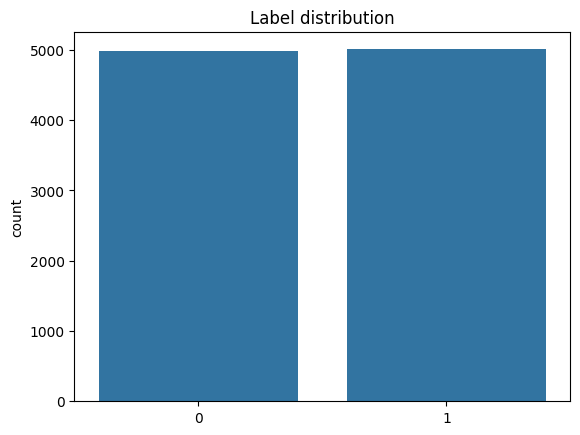

In [ ]:
train_batch,label_batch=next(iter(train_ds.batch(10)))
label = [lab.numpy() for text, lab in val_ds]
from collections import Counter
print(Counter(label))
sns.countplot(x=label)
plt.title('Label distribution')
plt.show()

In [ ]:
def Standarization(text):
  lowercase = tf.strings.lower(text)
  stripped_html = tf.strings.regex_replace(lowercase,'<br />',' ')
  return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation),'')



In [ ]:
max_features = 10000
sequence_length = 150
vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=Standarization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)


In [ ]:
train_text = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text.batch(512))

In [ ]:
def vectorize_text(text,label):
  # text = tf.expand_dims(text,-1)
  return vectorize_layer(text),label

In [ ]:

train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)
test_ds = test_ds.batch(32)

train_ds = train_ds.map(vectorize_text)
val_ds = val_ds.map(vectorize_text)
# test_ds = test_ds.map(vectorize_text)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
# BATCH_SIZE = 32
# train_ds = train_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
# val_ds   = val_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
# test_ds  = test_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [ ]:
model = tf.keras.Sequential([
    # vectorize_layer,
    tf.keras.layers.Embedding(max_features,64),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64,activation='relu',kernel_regularizer='l2'),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

In [ ]:
# BUFFER_SIZE = 10000
# BATCH_SIZE = 64

# # If you have raw text, use a TextVectorization layer inside the model
# # OR map it here.
# train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=10,
    callbacks=[callback]
)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - binary_accuracy: 0.5169 - loss: 0.9004 - val_binary_accuracy: 0.7367 - val_loss: 0.5265
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - binary_accuracy: 0.7975 - loss: 0.4752 - val_binary_accuracy: 0.8063 - val_loss: 0.4397
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - binary_accuracy: 0.8583 - loss: 0.3792 - val_binary_accuracy: 0.8206 - val_loss: 0.4107
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - binary_accuracy: 0.8825 - loss: 0.3286 - val_binary_accuracy: 0.8323 - val_loss: 0.3951
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - binary_accuracy: 0.9002 - loss: 0.2943 - val_binary_accuracy: 0.8384 - val_loss: 0.3887
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - binary_accuracy: 0.9132 - loss: 0.2676 - val_binary_accuracy: 0.8401 - val_loss: 0.3876
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - binary_accuracy: 0.9235 - loss: 0.2462 - val_binary_accuracy: 0.8423 - val_loss: 0.3886
Epoc

In [ ]:
loss,accuracy = model.evaluate(test_ds,verbose=1)
print('Loss:',loss)
print('Accuracy:',accuracy)

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.8274 - loss: 0.4107
Loss: 0.41109973192214966
Accuracy: 0.8240399956703186


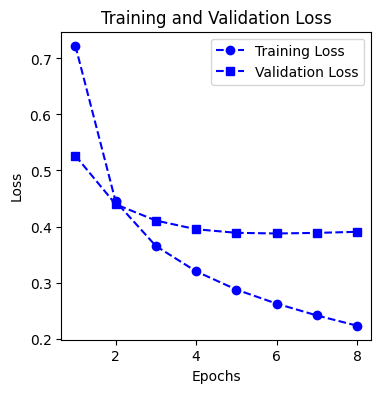

In [ ]:
history_dict = history.history
history_dict.keys()
bi_acc = history_dict['binary_accuracy']
val_bi_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs=range(1,len(bi_acc)+1)
plt.figure(figsize=(4,4))
plt.plot(epochs,loss,'bo--',label='Training Loss',)
plt.plot(epochs,val_loss,'bs--',label='Validation Loss',)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


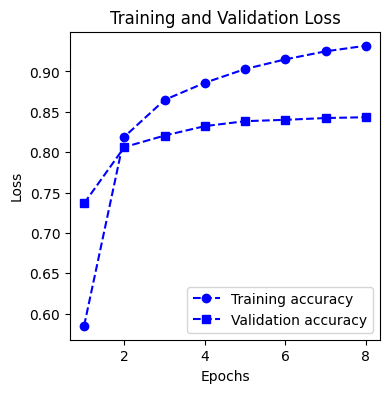

In [ ]:
plt.figure(figsize=(4,4))
plt.plot(epochs,bi_acc,'bo--',label='Training accuracy',)
plt.plot(epochs,val_bi_acc,'bs--',label='Validation accuracy',)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    tf.keras.layers.Activation('sigmoid')
])
export_model.compile(
    optimizer='adam',
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics = ['accuracy']
)
# metrics = export_model.evaluate(test_ds, return_dict=True)
# print(metrics)

In [ ]:
ex1 = tf.constant([
    'The movie was so good! I love this movie , price worthit',
    'the movie is shit , does not worth to see the  movie money waste',
    'do not watch,bad not worth waste , pure waste',
    'waste of time and the money at the same time'
    ])
pre_array = export_model.predict(ex1)
j = 1
for i in pre_array:
  if i > 0.5 :
    print(f'{j}th Review is Positive.')
  else:
    print(f'{j}th Review is Negative.')
print(pre_array)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1th Review is Positive.
1th Review is Negative.
1th Review is Negative.
1th Review is Negative.
[[0.76447874]
 [0.36038995]
 [0.20212734]
 [0.39533672]]
